<a href="https://colab.research.google.com/github/AmirMoazzami/207_final_project/blob/main/zillow_final_project_207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 Final Project: Zillow Prize: Zillow’s Home Value Prediction

*   List item
*   List item



* Gray Selby
* Amir Moazami
* Soroush Yazdani

In this competition, Zillow has requested participants to predict the log-error between their Zestimate and the actual sale price of homes, using all available features. The log error is calculated as the logarithm of the Zestimate divided by the logarithm of the SalePrice:

**logerror = log(Zestimate) - log(SalePrice)**

We have been provided with a comprehensive dataset containing real estate properties from three counties in California: Los Angeles, Orange, and Ventura, for the year 2016.

The training data consists of all property transactions that occurred before October 15, 2016, as well as some transactions that took place after that date.

The test data available in the public leaderboard includes the remaining transactions that occurred between October 15 and December 31, 2016.

The rest of the test data, which is used to calculate the private leaderboard scores, encompasses all the properties sold between October 15, 2017, and December 15, 2017. This particular period is referred to as the "sales tracking period," during which no submissions will be accepted.

Our objective is to make predictions for six specific time points across all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

When a property is sold multiple times within a 31-day period, we will consider the first reasonable value as the ground truth. The notion of "reasonable" entails selecting the transaction with a value that appears more accurate if the data seems questionable.

To begin, we will import the necessary libraries and obtain the dataset from Kaggle.com. Subsequently, we will conduct exploratory data analysis (EDA) to enhance the cleanliness of the dataset. Finally, we will employ basic machine learning techniques to establish a baseline model.









In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Datasets (Porperties for 2016 Data)
Zillow has provided us with two datasets for the years 2016 and 2017. To establish a baseline model, we will initially focus on the 2016 data. Once we have gained confidence in our approach and model performance, we can then incorporate the 2017 data into our analysis. This stepwise approach allows us to first ensure the effectiveness of our methodology before expanding it to include additional data.

In order to access data we put the data on the Google Drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading in the training data from the drive:

In [3]:
# Import the data from Google Drive
train_df = pd.read_csv("/content/drive/MyDrive/W207_Zillow/zillow-prize-1/train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.shape

(90275, 3)

In the next section, we will examine the dataset and perform data analysis to gain insights. Due to the large size of the data, it is necessary to conduct exploratory data analysis (EDA) in order to clean and preprocess it effectively.

In [4]:
# reading in the 2016 properties .csv file and get some info from it
prop_df = pd.read_csv("/content/drive/MyDrive/W207_Zillow/zillow-prize-1/properties_2016.csv")
prop_df.shape

<ipython-input-4-233ed4cd41bc>:2: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  prop_df = pd.read_csv("/content/drive/MyDrive/W207_Zillow/zillow-prize-1/properties_2016.csv")


(2985217, 58)

In [5]:
# creating new column and call it transaction_month
train_df['transaction_month'] = train_df['transactiondate'].dt.month
color = sns.color_palette()
# counting values
cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [7]:
# We're going to choose the simple approach by using the last transaction of the month for each row above as the ground truth.
train_df = train_df.sort_values("transactiondate").drop_duplicates(["parcelid"], keep = "last")
print(train_df.shape)

(90150, 4)


In [8]:
# counting the pacelid values
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()


1    90150
Name: parcelid, dtype: int64

Based on the information gathered, it appears that the notices we possess are associated with the state of California, specifically Los Angeles, Orange, and Ventura counties.

We currently have a total of 90,811 announcements in the training dataset, while the overall dataset comprises 2,985,217 announcements.

To proceed with our analysis, it is now appropriate to merge the two files, combining them into a single dataset. This consolidation will enable us to conduct more comprehensive and detailed analysis.

In [9]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [10]:
prop_df.columns


Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

Now let's check how many missing values we have:

In [11]:
# checking and counting the missing values
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df
dtype_df.groupby("Column Type").aggregate('count').reset_index()
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90107,0.999523
9,buildingclasstypeid,90134,0.999823
16,finishedsquarefeet13,90117,0.999634
44,storytypeid,90107,0.999523


That's a lot of missing values! So in the next section we will perform some EDA and cleaning the data.

## EDA and Correlation Analysis

In this section, our objective is to conduct exploratory data analysis (EDA) in order to gain a deeper understanding of the relationships between the variables. We will begin by addressing missing values by substituting them with the medians of their respective columns. Following that, we will generate a correlation coefficient plot to examine the correlations between the variables. This analysis will provide valuable insights into the interdependencies among the variables and aid in our subsequent modeling and decision-making processes.

<ipython-input-12-2b6b92b9b8b0>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  median_values = train_df.mean(axis=0)
<ipython-input-12-2b6b92b9b8b0>:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  median_values = train_df.mean(axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


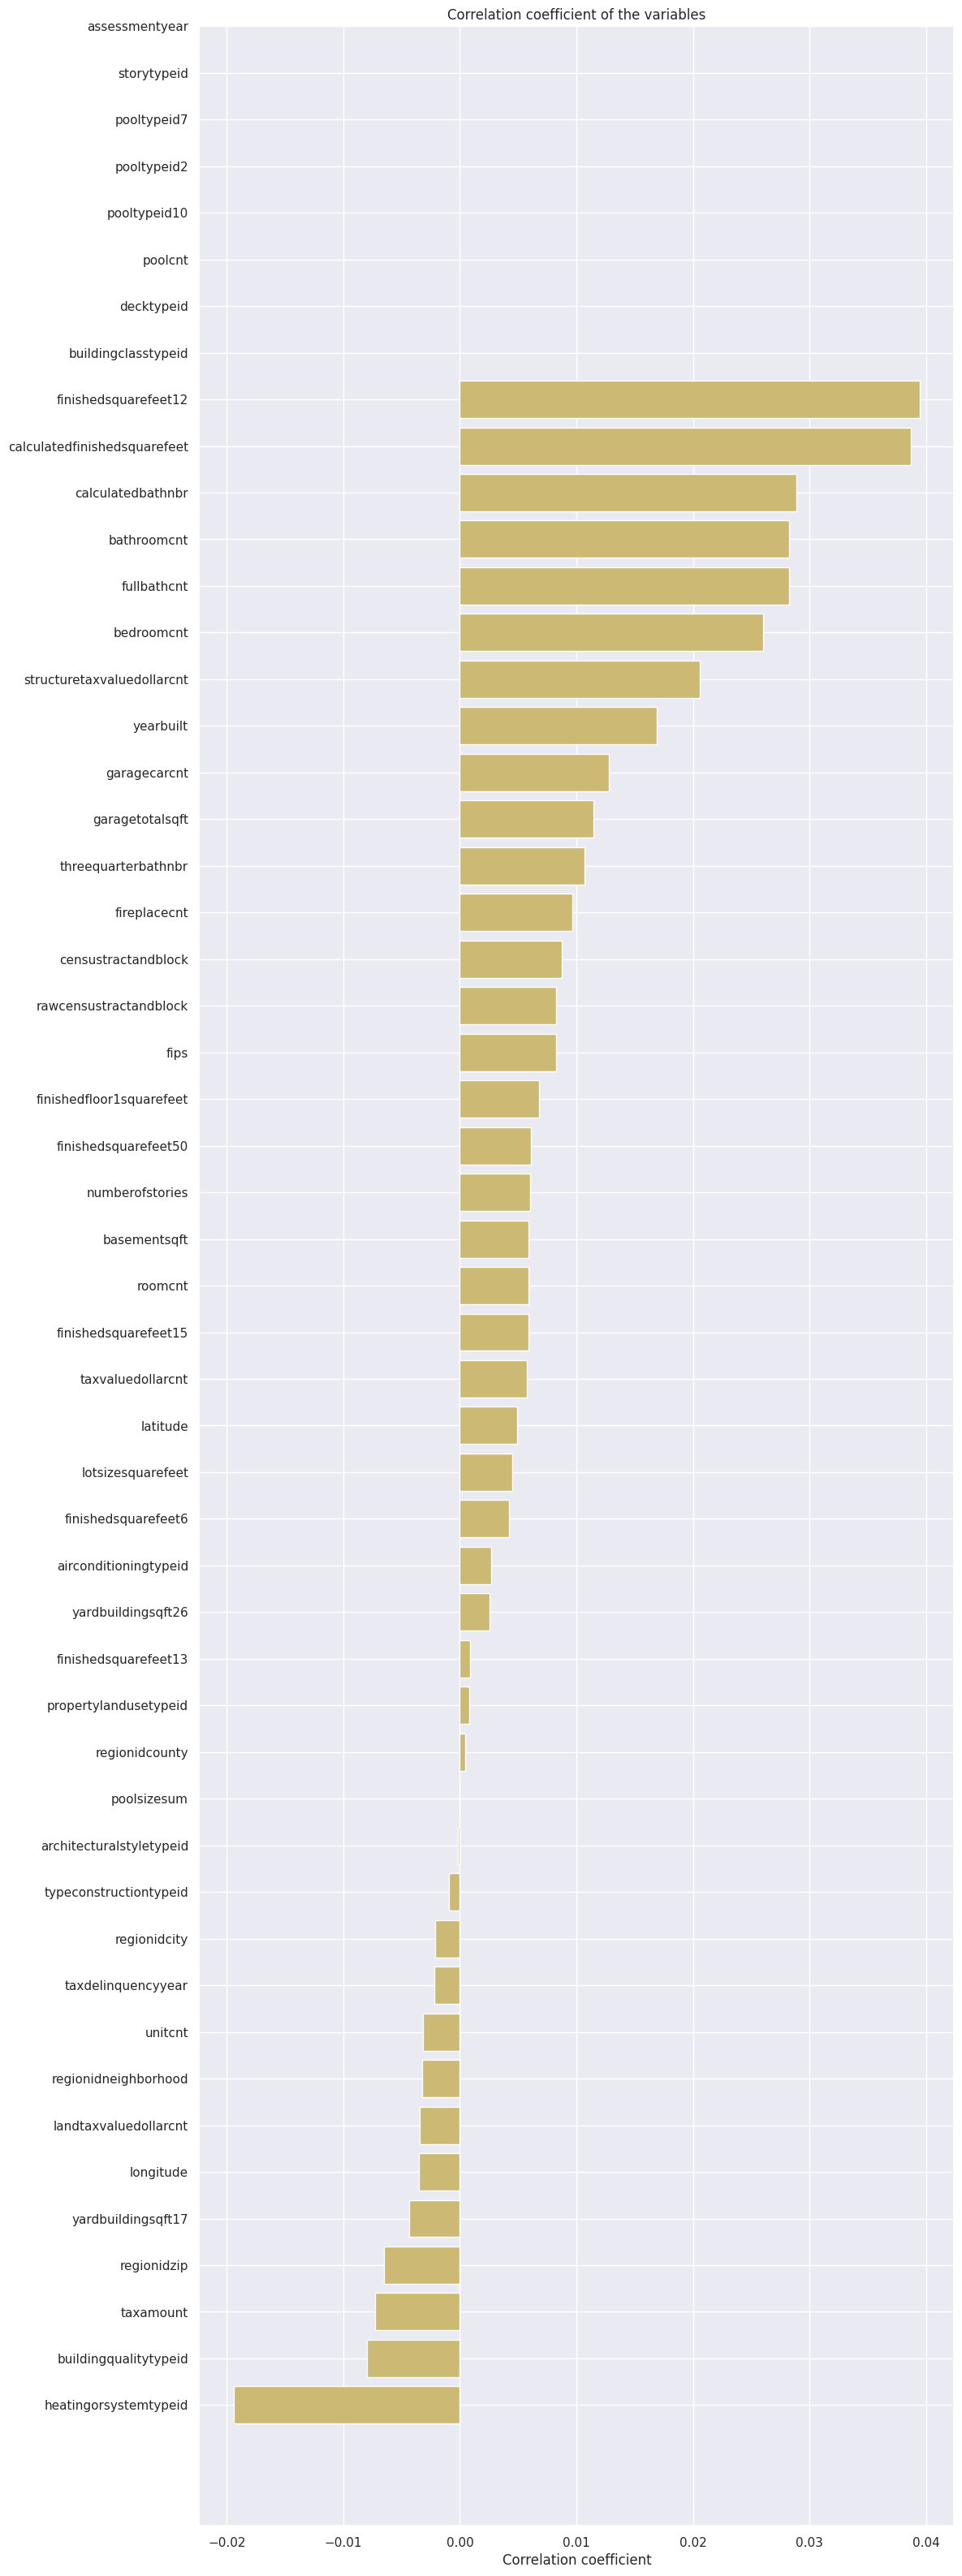

In [12]:
# Let us just impute the missing values with median values (instead of mean) to compute correlation coefficients #
#mean_values = train_df.mean(axis=0)
#train_df_new = train_df.fillna(mean_values, inplace=True)
median_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(median_values, inplace=True)

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [13]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


Let's test the correlated values and remove the datas that have correlation between -0.01 and 0.02.

In [14]:
# removing correlation between -0.01 and 0.2
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel


,col_labels,corr_values
21,heatingorsystemtypeid,-0.019420
45,structuretaxvaluedollarcnt,0.020603
4,bedroomcnt,0.026032
18,fullbathcnt,0.028254
3,bathroomcnt,0.028259
7,calculatedbathnbr,0.028831
10,calculatedfinishedsquarefeet,0.038646
11,finishedsquarefeet12,0.039449


Now let's plotting the important variables correlation again. We want to make sure we pick the most relevant values.

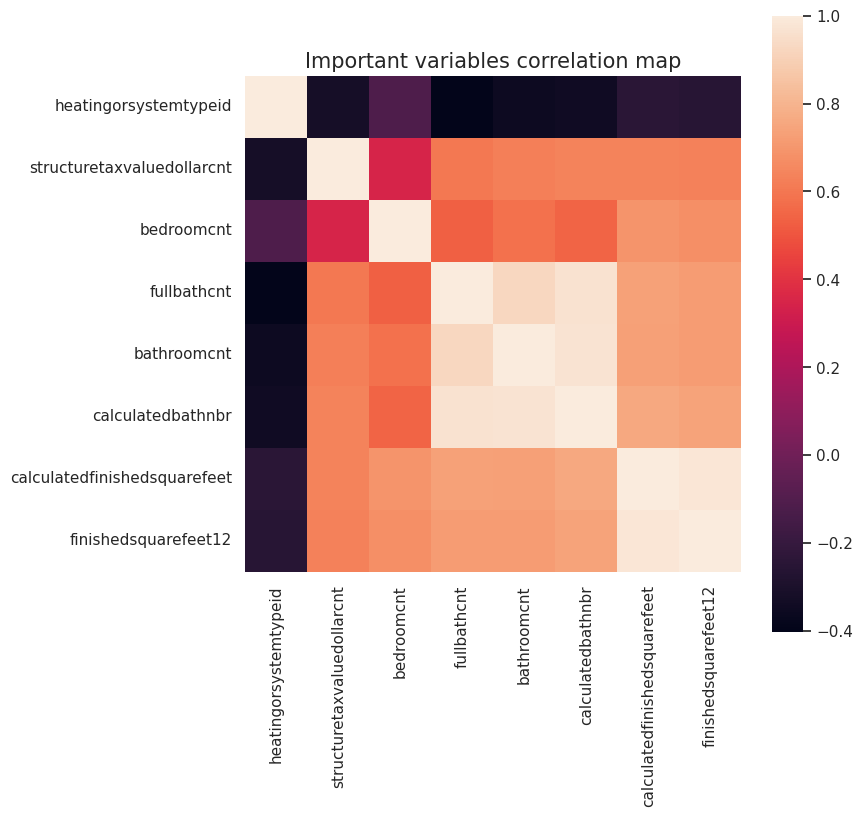

In [15]:
# Plotting the important variables correlation

cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [16]:
# displaying the final train_df
display(train_df)

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.000000,7.230769,713.581395,2.0,3.0,4.0,...,1.440798,1.0,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,13.40169,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,1.815222,7.230769,713.581395,3.5,4.0,4.0,...,1.440798,1.0,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,13.40169,6.049153e+13
2,12098116,-0.0040,2016-01-01,1,1.000000,7.230769,713.581395,3.0,2.0,4.0,...,1.440798,1.0,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,13.40169,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.000000,7.230769,713.581395,2.0,2.0,4.0,...,1.440798,1.0,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,13.40169,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,1.815222,7.230769,713.581395,2.5,4.0,4.0,...,2.000000,1.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,13.40169,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90145,12819764,0.1151,2016-12-30,12,1.815222,7.230769,713.581395,3.0,6.0,4.0,...,1.440798,1.0,282871.0,550740.0,2015.0,267869.0,7795.55,NaN,13.40169,6.037409e+13
90146,11206485,0.0227,2016-12-30,12,1.000000,7.230769,713.581395,2.0,3.0,4.0,...,1.440798,1.0,119859.0,149822.0,2015.0,29963.0,2830.25,NaN,13.40169,6.037911e+13
90147,11831984,-0.0576,2016-12-30,12,1.815222,7.230769,713.581395,1.0,3.0,4.0,...,1.440798,1.0,22008.0,30962.0,2015.0,8954.0,605.99,NaN,13.40169,6.037532e+13
90148,14118061,-0.0020,2016-12-30,12,1.815222,7.230769,713.581395,2.0,4.0,4.0,...,1.000000,1.0,100322.0,451091.0,2015.0,350769.0,5393.00,NaN,13.40169,6.059086e+13


We are curious to see how these house spread out around LA. So let's plot the longitude and lititude plot.

<Axes: xlabel='longitude', ylabel='latitude'>

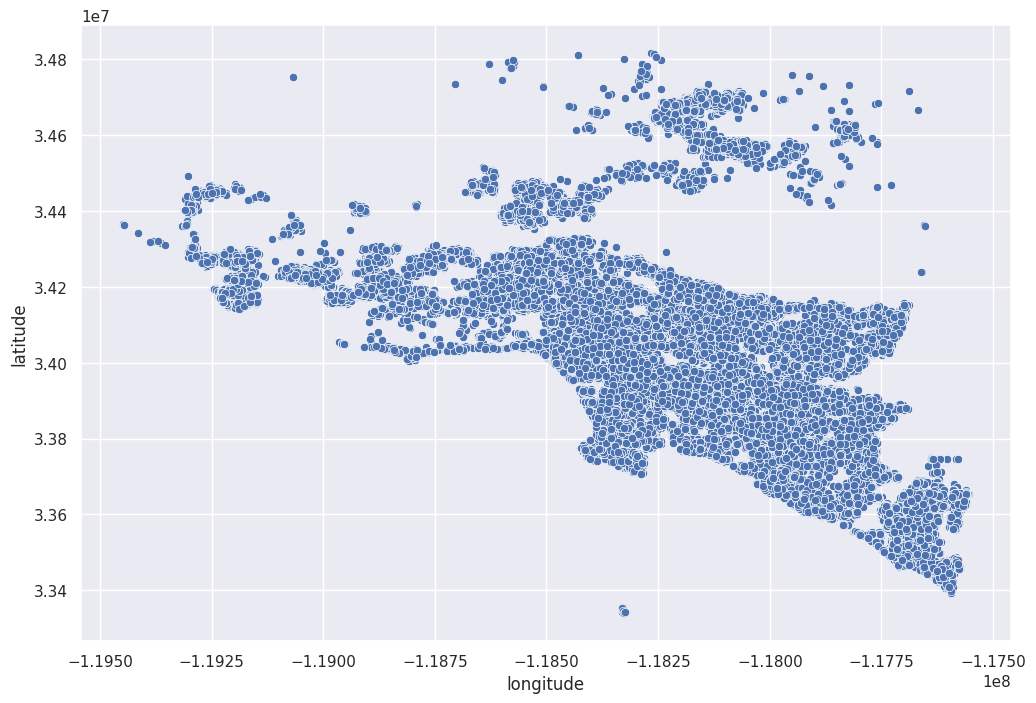

In [17]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude',y='latitude',data=train_df)

That pretty much very similar to google map picture. For some resoan the satelite picture doesn't show up after saving it to the git hub.

![](https://drive.google.com/uc?export=view&id=1ffaNzw2p8MJWOg3lHRQ98reoL1AlB4Oe)


If you take a closer look you will see the line betweer counties and the water.

# Feature Selection

We used **ExtraTreesRegressor** library from Sklearn library here to find which features are the most important ones. Sklearn uses other libraries such as Random Forest, Gradient Boosting, AdaBoost regressor libraries to perform regression tasks. We will study those libraries in depth later.

Also, we are getting rid of the below features since they don't have good correlation with data:


* "hashottuborspa"
* "propertycountylandusecode"
* "propertyzoningdesc"
* "fireplaceflag"
* "taxdelinquencyflag"



In [18]:
# let's just make a copy of train_df so we have the original one
train_df_orig = train_df

In [19]:
# Let's get rid of some of useless columns :D
train_y = train_df_orig['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df_orig.drop(['parcelid', 'logerror', 'transactiondate', 'transactiondate']+cat_cols, axis=1)
feat_names = train_df.columns.values

Now we are using ExtraTreesRegressor library to predict which features are the most important one:

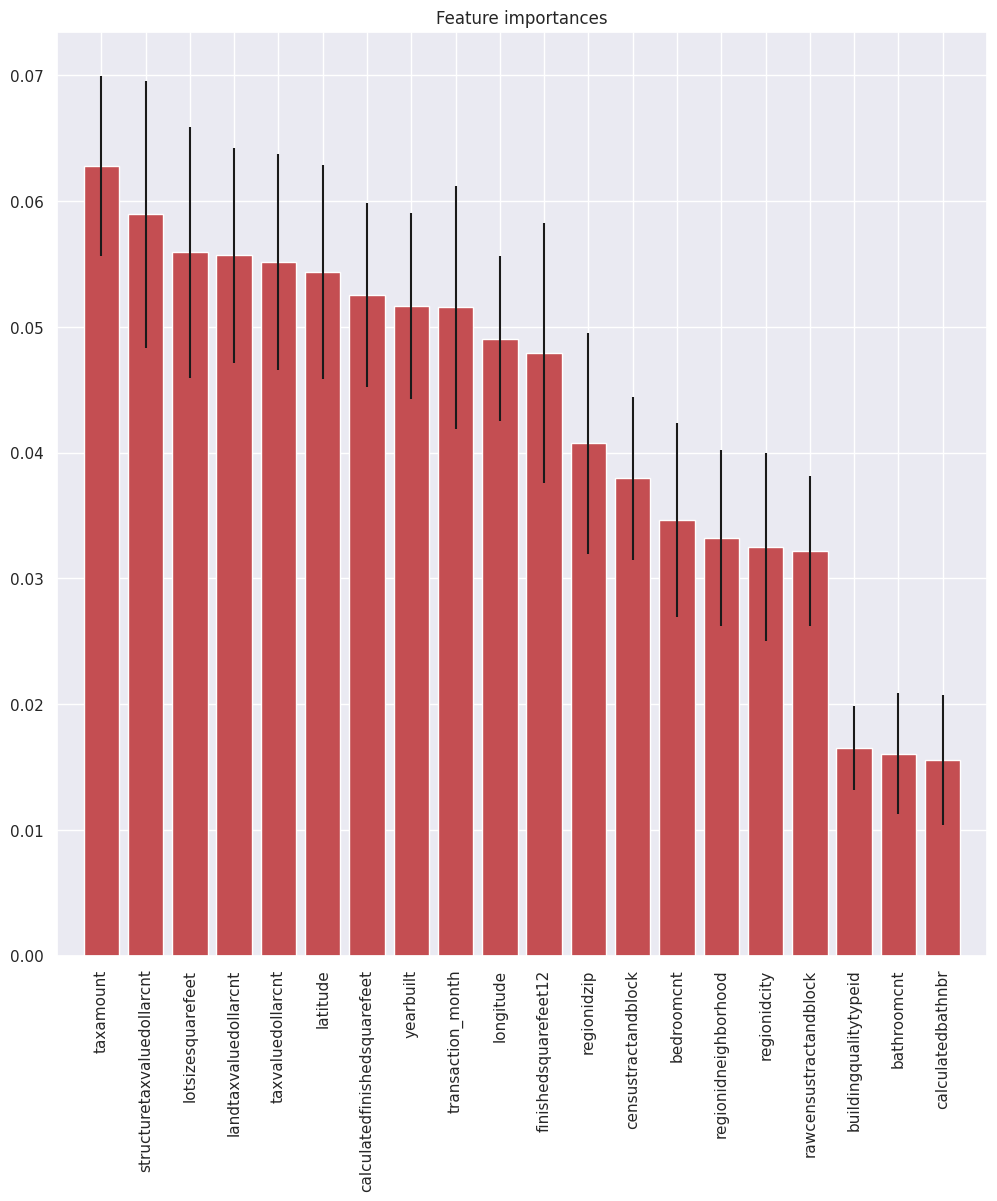

In [20]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()


In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90150 entries, 0 to 90149
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transaction_month             90150 non-null  int64  
 1   airconditioningtypeid         90150 non-null  float64
 2   architecturalstyletypeid      90150 non-null  float64
 3   basementsqft                  90150 non-null  float64
 4   bathroomcnt                   90150 non-null  float64
 5   bedroomcnt                    90150 non-null  float64
 6   buildingclasstypeid           90150 non-null  float64
 7   buildingqualitytypeid         90150 non-null  float64
 8   calculatedbathnbr             90150 non-null  float64
 9   decktypeid                    90150 non-null  float64
 10  finishedfloor1squarefeet      90150 non-null  float64
 11  calculatedfinishedsquarefeet  90150 non-null  float64
 12  finishedsquarefeet12          90150 non-null  float64
 13  f

Based on our analysis, it appears that the tax amount variable exhibits the strongest correlation with the source variable. Therefore, for our baseline model, we can argue that the tax amount could be our main feature which influence the price. This will serve as a starting point for our model, allowing us to assess its performance.

In the upcoming section, we will construct a few simple models to establish a baseline for our analysis. These initial models will serve as a foundation from which we can further enhance and refine our predictions for the final project. By developing these baseline models, we can better understand the performance and limitations of our current approach, allowing us to make informed decisions and improvements in subsequent stages.

# Building Some Models and Defining Baseline Models

Firstly, we utilize the TensorFlow library, which we have learned from class and previous assignments, to assess its suitability for this dataset. By applying TensorFlow, we aim to gauge its capabilities and evaluate its performance in handling the given data.

Next, we incorporate the Lasso model from the Sklearn library. This particular model was chosen based on recommendations and advice found on the Kaggle website. However, it is important to note that our analysis of this model, along with other models, will be more extensively studied and investigated in the final project.

Through the implementation of these baseline models, we will gain insights into their effectiveness and begin building a strong foundation upon which we can refine and improve our predictions in subsequent stages.

In [25]:
# importing sklearn libraries
from sklearn.preprocessing import StandardScaler , RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split , cross_val_predict , RandomizedSearchCV
from sklearn.linear_model import Ridge , Lasso , ElasticNet
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor , ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn import linear_model

We want to split our data just one time, and then use different approaches. We want to be able to compare the different approaches. So let's do it here first and and then scale the train and test inputs:

In [26]:
# Using sklearn to split the train and test data
X_train , X_test , y_train , y_test = train_test_split(train_df , train_y , test_size=0.15 , shuffle=True , random_state=55)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#CNN (Baseline)

Ok let's add more layers to our training data set and change the baseline model. Uri wasn't happy with previous baseline model so I am making it more complex:


In [27]:
model = Sequential()
model.add(Dense(53, activation='relu'))
model.add(Dense(53, activation='relu'))
model.add(Dense(53, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [28]:
#Defining call backs so we stop overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test), batch_size=512,epochs=100, callbacks=[early_stop])

Epoch 1/100
150/150 [==============================] - 5s 10ms/step - loss: 0.0284 - val_loss: 0.0248
Epoch 2/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0261 - val_loss: 0.0248
Epoch 3/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0261 - val_loss: 0.0247
Epoch 4/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0261 - val_loss: 0.0248
Epoch 5/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0261 - val_loss: 0.0247
Epoch 6/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0261 - val_loss: 0.0247
Epoch 7/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0260 - val_loss: 0.0247
Epoch 8/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0260 - val_loss: 0.0247
Epoch 9/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0260 - val_loss: 0.0247
Epoch 10/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0260 - val_l

<Axes: >

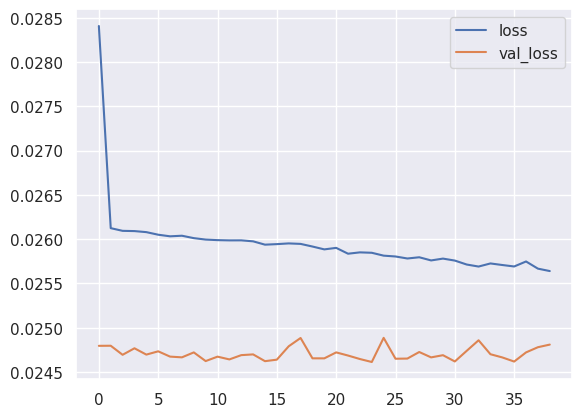

In [29]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [30]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Dense(53, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(53, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(53, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [31]:
model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test), batch_size=512,epochs=100, callbacks=[early_stop])

Epoch 1/100
150/150 [==============================] - 2s 9ms/step - loss: 0.0349 - val_loss: 0.0248
Epoch 2/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0262 - val_loss: 0.0248
Epoch 3/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0262 - val_loss: 0.0248
Epoch 4/100
150/150 [==============================] - 2s 10ms/step - loss: 0.0261 - val_loss: 0.0248
Epoch 5/100
150/150 [==============================] - 2s 12ms/step - loss: 0.0261 - val_loss: 0.0248
Epoch 6/100
150/150 [==============================] - 2s 12ms/step - loss: 0.0261 - val_loss: 0.0248
Epoch 7/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0261 - val_loss: 0.0248
Epoch 8/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0261 - val_loss: 0.0248
Epoch 9/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0261 - val_loss: 0.0248
Epoch 10/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0261 - val

<Axes: >

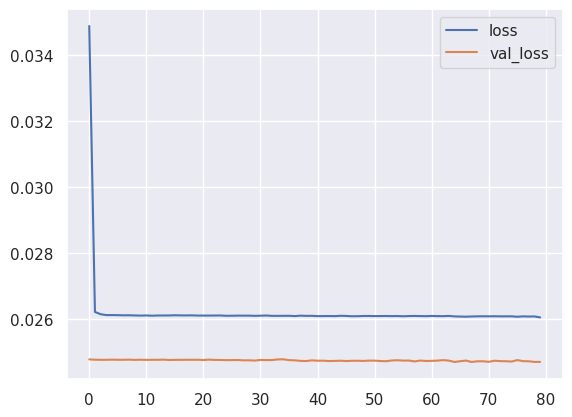

In [32]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [33]:
predictions = model.predict(X_test)
mse=mean_absolute_error(y_test, predictions)
r2=r2_score(y_test,predictions)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


423/423 [==============================] - 1s 2ms/step
Mean Squared Error: 0.06764664911908223
R-squared: 0.002157019885665412


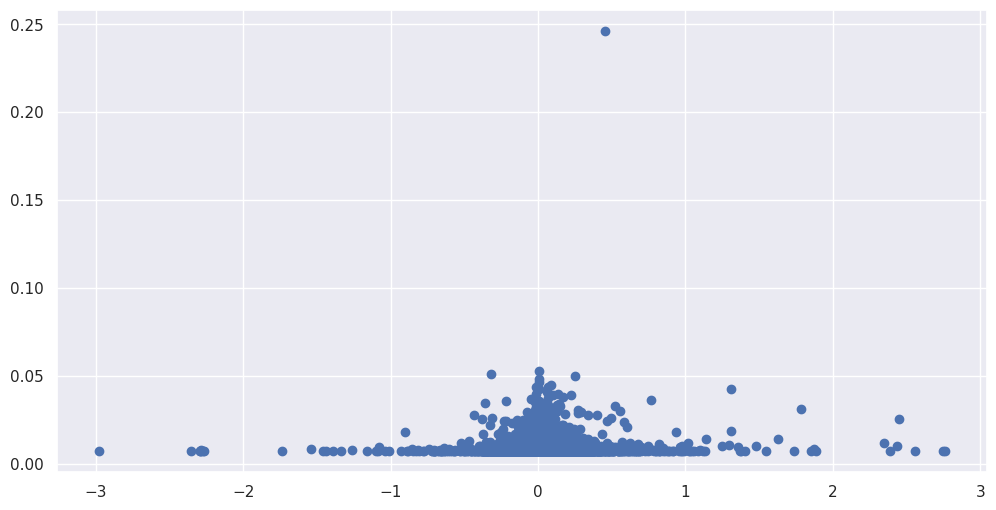

In [34]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,predictions)

Man! thant sucks. But let's see if we can do anything with Random Forest regression model.

Well, not bad! Our loss after 100 iteration is around 58. but this took a very long time to converge. We might need to bring down the epochs cycle. Also, we need to add more features to the model later. But for Baseline this is a good start.

## Lasso Model from Sklearn

In next step let's try something new. We used **Lasso**, **CNN**, **Random Forrest** and **XGBoost** model from Sklearn library. In scikit-learn, the Lasso model refers to the Lasso regression algorithm, which is a linear regression model that incorporates L1 regularization.

Lasso regression is a type of linear regression that performs both variable selection and regularization by adding a penalty term to the ordinary least squares (OLS) objective function.

We picked this model based on the suggestion that we found on the Kaggle notebooks. We will dive more into this model and other Sklearn models in our final project.

## Lasso

The Lasso regression model is a linear regression technique that includes L1 regularization, which encourages sparsity in the model coefficients. This can be useful for feature selection and handling multicollinearity.

In [35]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Create and fit the Lasso regression model
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lasso_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.02476408368516373
R-squared: -5.6529079195399845e-08


 The alpha parameter controls the strength of the regularization. A smaller alpha encourages stronger regularization and can lead to more coefficients being set to zero. We used alpha 0.01 here just to see how model works

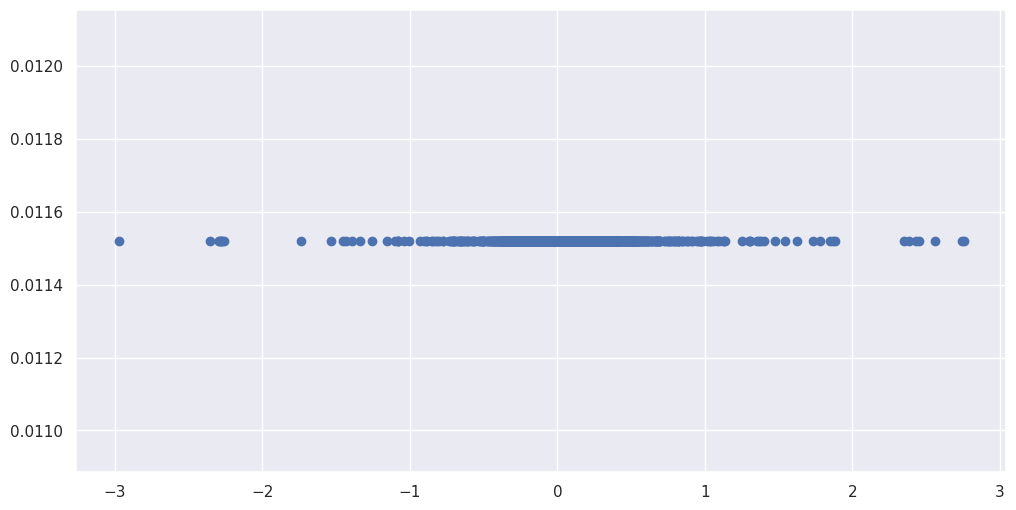

In [36]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,y_pred)

Let's check how many nurouns we need:

In [37]:
X_train.shape
train_df.head()


,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,1,1.000000,7.230769,713.581395,2.0,3.0,4.0,4.000000,2.0,66.0,...,311.694737,1959.0,1.440798,122754.0,360170.0,2015.0,237416.0,6735.88,13.40169,6.037107e+13
1,1,1.815222,7.230769,713.581395,3.5,4.0,4.0,5.565393,3.5,66.0,...,311.694737,2014.0,1.440798,346458.0,585529.0,2015.0,239071.0,10153.02,13.40169,6.049153e+13
2,1,1.000000,7.230769,713.581395,3.0,2.0,4.0,4.000000,3.0,66.0,...,311.694737,1940.0,1.440798,61994.0,119906.0,2015.0,57912.0,11484.48,13.40169,6.037464e+13
3,1,1.000000,7.230769,713.581395,2.0,2.0,4.0,4.000000,2.0,66.0,...,311.694737,1987.0,1.440798,171518.0,244880.0,2015.0,73362.0,3048.74,13.40169,6.037296e+13
4,1,1.815222,7.230769,713.581395,2.5,4.0,4.0,5.565393,2.5,66.0,...,311.694737,1981.0,2.000000,169574.0,434551.0,2015.0,264977.0,5488.96,13.40169,6.059042e+13


## Random Forrest

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Using sklearn to split the train and test data
#X_train , X_test , y_train , y_test = train_test_split(train_df , train_y , test_size=0.15 , shuffle=True , random_state=55)

# Create and fit the Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.025254541617319454
R-squared: -0.019805269841885798


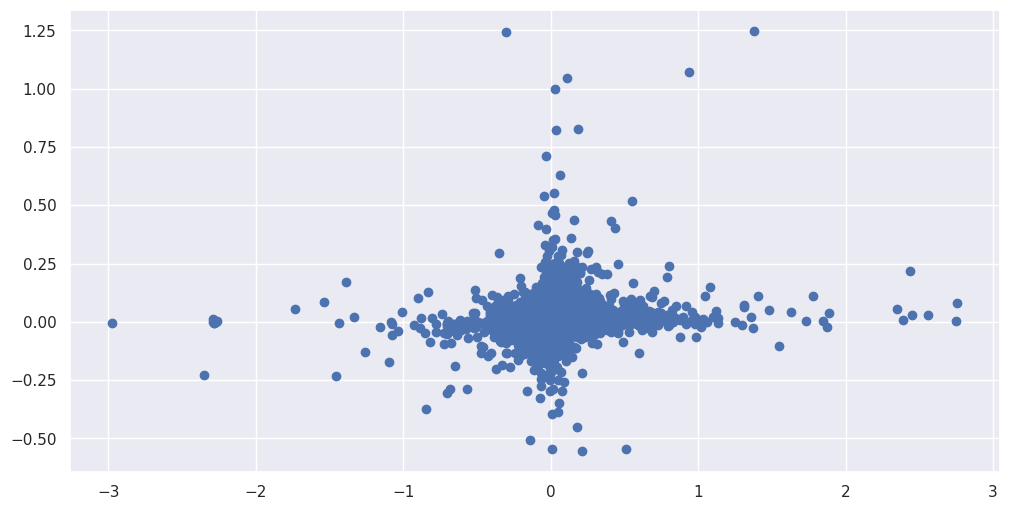

In [39]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,y_pred)

## XGBoost

In [40]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Create and fit the XGBoost regression model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.02588025907119286
R-squared: -0.045072406603320125


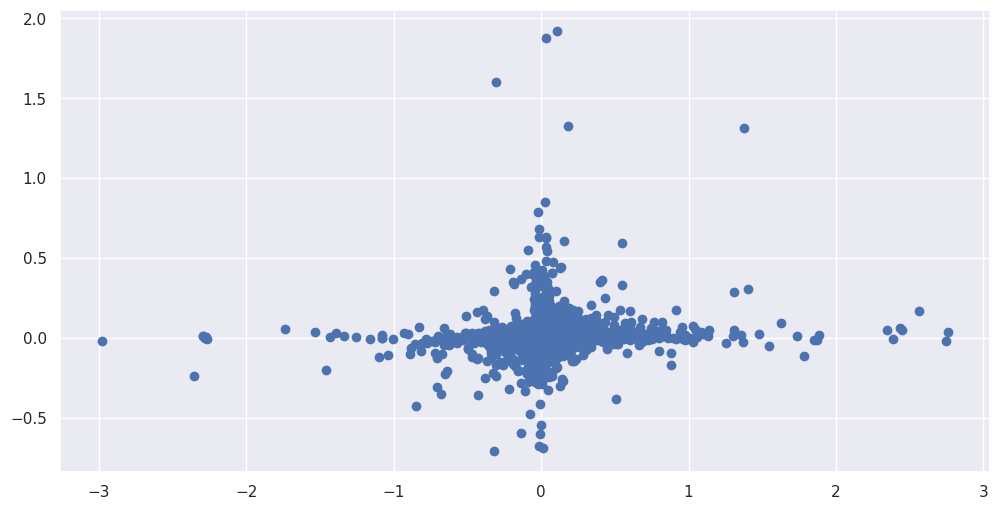

In [41]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,y_pred)

## KNN

In [42]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Create and fit the KNN regression model
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.03253821178929725
R-squared: -0.3139276236635473


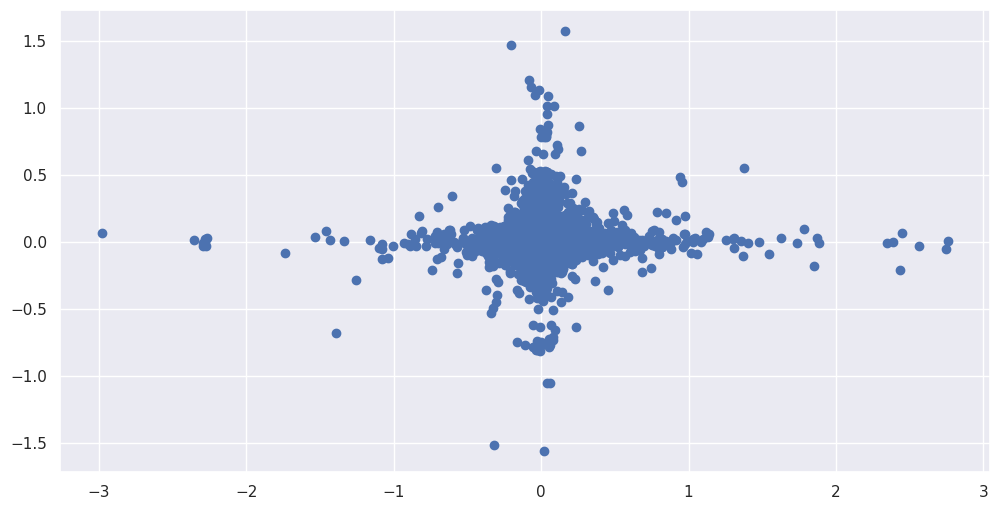

In [43]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,y_pred)

## Results
So let's put a chart for all of the model that we have been tried so far and see what we got.

| Model name | MSE |  R^2 |
|:-:                |:-:                  |:-:           |
| **Lasso**              | 0.07                | 0.0004       
| **CNN**                | 0.069               | 0.00005      
| **Random Forest**      | 0.027               | 0.027   
| **XGBoost**            | 0.027               | 0.02   
| **KNN**                | 0.03                |  0.3


Overall, the models are struggling. It seems the R2 values sometimes get negative values which could mean the model is performing poorly.

Feauter work:
- add 2017 data
- stick with one ML model and try to study and improvite just by playing with hyperparameters
